#### This notebook plots the strength of the AMOC as a time series.

In [7]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.optimize import curve_fit
from xhistogram.xarray import histogram
from collections import OrderedDict

from dask.distributed import Client

%matplotlib inline

In [2]:
client = Client(n_workers=8)
display(client)

Client Scheduler: tcp://127.0.0.1:37777 Dashboard: /proxy/38773/status,Cluster Workers: 8 Cores: 8 Memory: 128.85 GB


In [3]:
### Generate new database

db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt_spinup500.db'

session = cc.database.create_session(db)

In [4]:
cc.querying.get_experiments(session)

,experiment,ncfiles
0,1deg_jra55_ryf_cont,150429
1,output111,2096
2,output112,2096
3,output113,2096
4,output114,2096
5,output115,2096
6,output116,2096
7,output117,2096
8,output118,2096
9,output119,2096


In [19]:
exptdict = OrderedDict([
    ('Warming',  {'expt': '1deg_jra55_ryf_rcp45warm_x1_spinup500'}),
    ('Warming x2',  {'expt': '1deg_jra55_ryf_rcp45warm_x2_spinup500'}),
    ('Cooling',  {'expt': '1deg_jra55_ryf_rcp45cool_x1_spinup500'}),
    ('Cooling x2',  {'expt': '1deg_jra55_ryf_rcp45cool_x2_spinup500'})
])
# contdict = OrderedDict([
#     ('2400-2454', {'expt': '1deg_jra55_ryf_cont'}),
#     ('2455-2459', {'expt': 'output111'}),
#     ('2460-2464', {'expt': 'output112'}),
#     ('2465-2469', {'expt': 'output113'}),
#     ('2470-2474', {'expt': 'output114'}),
#     ('2475-2479', {'expt': 'output115'}),
#     ('2480-2484', {'expt': 'output116'}),
#     ('2485-2489', {'expt': 'output117'}),
#     ('2490-2494', {'expt': 'output118'}),
#     ('2495-2499', {'expt': 'output119'}),
# ])

1deg_jra55_ryf_rcp45warm_x1_spinup500
1deg_jra55_ryf_rcp45warm_x2_spinup500
1deg_jra55_ryf_rcp45cool_x1_spinup500
1deg_jra55_ryf_rcp45cool_x2_spinup500
CPU times: user 5min 53s, sys: 8.69 s, total: 6min 2s
Wall time: 6min 49s


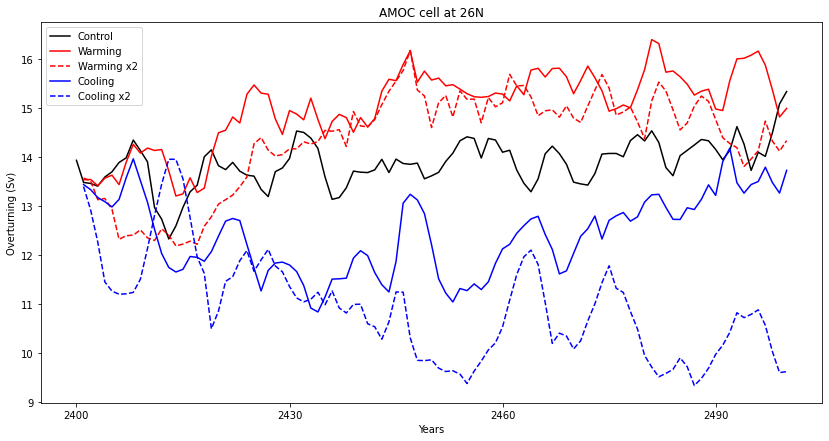

In [23]:
%%time
#contkeys = ['2400-2454', '2455-2459', '2460-2464', '2465-2469', '2470-2474', '2475-2479', '2480-2484', '2485-2489', '2490-2494', '2495-2499']
keys = ['Warming','Warming x2','Cooling','Cooling x2']
colors = {'Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b'} #{'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b'}
linestyles = {'Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--'} #{'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--'}
yr_beg = '2400-01-01'

plt.figure(figsize=(14, 7))
    
# Control

var = xr.concat([cc.querying.getvar('1deg_jra55_ryf_cont', 'ty_trans_rho', session, start_time = yr_beg),
                       cc.querying.getvar('output111', 'ty_trans_rho', session),
                       cc.querying.getvar('output112', 'ty_trans_rho', session),
                       cc.querying.getvar('output113', 'ty_trans_rho', session),
                       cc.querying.getvar('output114', 'ty_trans_rho', session),
                       cc.querying.getvar('output115', 'ty_trans_rho', session),
                       cc.querying.getvar('output116', 'ty_trans_rho', session),
                       cc.querying.getvar('output117', 'ty_trans_rho', session),
                       cc.querying.getvar('output118', 'ty_trans_rho', session),
                       cc.querying.getvar('output119', 'ty_trans_rho', session)], dim = 'time')
psi_amoc = var.sel(grid_xt_ocean = slice(- 103, - 5)).sum('grid_xt_ocean').sel(method = 'Nearest', grid_yu_ocean = 26) * 1.0e-9
psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
try:
    var2 = xr.concat([cc.querying.getvar('1deg_jra55_ryf_cont', 'ty_trans_rho_gm', session, start_time = yr_beg),
                       cc.querying.getvar('output111', 'ty_trans_rho_gm', session),
                       cc.querying.getvar('output112', 'ty_trans_rho_gm', session),
                       cc.querying.getvar('output113', 'ty_trans_rho_gm', session),
                       cc.querying.getvar('output114', 'ty_trans_rho_gm', session),
                       cc.querying.getvar('output115', 'ty_trans_rho_gm', session),
                       cc.querying.getvar('output116', 'ty_trans_rho_gm', session),
                       cc.querying.getvar('output117', 'ty_trans_rho_gm', session),
                       cc.querying.getvar('output118', 'ty_trans_rho_gm', session),
                       cc.querying.getvar('output119', 'ty_trans_rho_gm', session)], dim = 'time')
    psi_amoc_gm = var2.sel(grid_xt_ocean = slice( - 103, - 5)).sum('grid_xt_ocean').sel(method = 'Nearest', grid_yu_ocean = 26) * 1.0e-9
    psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
except:
    print('GM term not found')
        
psi_amoc_sum = psi_amoc_sum.sel(potrho = slice(1035.5, None)).max('potrho').resample(time = 'Y').mean()
psi_amoc_sum.plot(label = 'Control', color = 'k', linestyle = '-')

# Perturbations

for ekey in exptdict:
    expt = exptdict[ekey]['expt']
    print(expt)
    
    var = cc.querying.getvar(expt, 'ty_trans_rho', session, start_time = yr_beg)
    psi_amoc = var.sel(grid_xt_ocean = slice(- 103, - 5)).sum('grid_xt_ocean').sel(method = 'Nearest', grid_yu_ocean = 26) * 1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm', session, start_time = yr_beg)
        psi_amoc_gm = var2.sel(grid_xt_ocean = slice( - 103, - 5)).sum('grid_xt_ocean').sel(method = 'Nearest', grid_yu_ocean = 26) * 1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(potrho = slice(1035.5, None)).max('potrho').resample(time = 'Y').mean()
    psi_amoc_sum.plot(label = ekey, color = colors[ekey], linestyle = linestyles[ekey])
    
xlims = plt.xlim()
plt.xlabel('Years')
plt.ylabel('Overturning (Sv)')
plt.legend()
plt.title('AMOC cell at 26N')
#plt.savefig('AMOC_26N_2400-2500.jpg')